In [1]:
import os
import json
import gym
from gym import wrappers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count 
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [2]:
#torch.manual_seed(0)
#np.random.seed(12345)

In [3]:
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
env = wrappers.Monitor(gym.make("CartPole-v0"), "./video", force=True)

## Approach
- This is a little different from the Double Q-learning described in Sutton's book.
- It is actually that used by Mnih and show in PyTorch's RL tutorial

In [6]:
class QNet(nn.Module):
    
    def __init__(self, n_inputs, n_outputs,
                 hidden_layer_sizes=[8, 8]):
        
        super().__init__()
        
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        layer_sizes = [n_inputs] + hidden_layer_sizes + [n_outputs]
        
        self.layers = []
        
        for s_in, s_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            
            self.layers.append(nn.Linear(s_in, s_out))
            
        self.params = []
        
        for l in self.layers:
            
            self.params.extend(l.parameters())
            
        self.params = nn.ParameterList(self.params)
        
        return
    
    def forward(self, x):
        
        for l in self.layers:
            
            x = F.relu(l(x))
            
        return x
    
    
class ReplayMemory(object):
    
    def __init__(self, max_memory, batch_size):
        
        self.memory = []
        self.max_memory = max_memory
        self.batch_size = batch_size
        
        return
    
    def remember(self, cur_state, next_state, action, reward, is_done):
        
        self.memory.append((cur_state, next_state, action, reward, is_done))
            
        if len(self.memory) >= self.max_memory:
            
            self.memory = self.memory[-self.max_memory:]
            
        return
    
    def sample(self):
        
        return random.sample(self.memory, self.batch_size)
    
    def __len__(self):
        
        return len(self.memory)
    
def to_torch(x, device):
    
    return torch.tensor(x, dtype=torch.float32, device=device)

In [7]:
class Agent(object):
    
    def __init__(self, name, n_inputs, n_actions,
                 hidden_layer_sizes,
                 memory_capacity=5000, batch_size=64,
                 epsilon=(0.99, 0.9999, 0.05, 100, 1.05, 1.01), gamma=0.99,
                 update_every=50, eval_mode=False,
                 model_params_path=None, optimizer_args={}):
        
        self.name = name
        self.writer = SummaryWriter(os.path.join(self.name, "logs"))
        
        self.memory = ReplayMemory(memory_capacity, batch_size)
        self.total_experience = 0
        self.epsilon_max, self.epsilon_decay, \
            self.epsilon_min, self.epsilon_update_every, \
            self.epsilon_scale, self.min_score_improve = epsilon
        
        self.epsilon = self.epsilon_max
        
        self.n_inputs = n_inputs
        self.n_actions = n_actions
        self.gamma = gamma
        
        self.target_net = QNet(n_inputs, n_actions, hidden_layer_sizes).to(device)
        self.policy_net = QNet(n_inputs, n_actions, hidden_layer_sizes).to(device)
        self.optimizer = optimizer = optim.RMSprop(self.policy_net.parameters(), **optimizer_args)
        self.criteria = nn.MSELoss()
        self.update_every = update_every
        
        self.target_net.eval()
        self.update_target_net()
        
        if model_params_path is not None:
            
            self.target_net.load_state_dict(torch.load(model_params_path))
            
            self.policy_net.load_state_dict(torch.load(model_params_path))
        
        if eval_mode:

            self.policy_net.eval()
        
        self.score_history = []
        
        return
    
    def remember(self, *args):
        
        self.total_experience += 1
        
        self.memory.remember(*args)
        
    def act(self, cur_state):
        
        state_value = self.policy_net(cur_state)
        
        if np.random.rand() <= self.epsilon:
            
            action = np.random.randint(self.n_actions)
            
        else:
            
            with torch.no_grad():
            
                action = state_value.argmax().item()
                
        self.epsilon = np.max([self.epsilon * self.epsilon_decay, self.epsilon_min])
                
        return action
    
    def adjust_exploration_behavior(self):
        
        prev_ave_score = np.mean(self.score_history[-2 * self.epsilon_update_every : -self.epsilon_update_every])
        cur_ave_score = np.mean(self.score_history[-self.epsilon_update_every:])
        
        delta_score = (cur_ave_score - prev_ave_score) / prev_ave_score
        
        if delta_score < self.min_score_improve:
            
            self.epsilon = np.min([self.epsilon_max, self.epsilon * self.epsilon_scale])
            
        return
    
    def update_target_net(self):
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return
    
    def learn(self):
        
        if len(self.memory) < 3 * self.memory.batch_size:
            
            return
        
        else:
            
            cur_states_, next_states_, actions_, rewards_, is_done_ = \
                zip(*self.memory.sample())
            
            action_batch = torch.cat(actions_).type(torch.long).view(-1, 1)
            
            state_value_batch = self.policy_net(torch.cat(cur_states_).view(-1, n_inputs)).gather(1, action_batch)
            
            reward_batch = torch.cat(rewards_).view(-1, 1)
            
            is_done_batch = torch.tensor(is_done_, dtype=torch.bool, device=device)
            
            with torch.no_grad():
                
                next_state_value_batch = self.target_net(torch.cat(next_states_).view(-1, n_inputs)).max(1, keepdim=True).values.detach()
                
                next_state_value_batch[is_done_batch] = 0
            
            loss = self.criteria(state_value_batch,
                                 reward_batch + (self.gamma * next_state_value_batch))
            
            self.optimizer.zero_grad()
            
            loss.backward()
            
            self.optimizer.step()
                
            return

In [8]:
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n
hidden_layer_sizes = [8, 8]

episode_length = 200
max_episodes = 1000
batch_size = 64
update_every = 10
report_every = 500

output_dir = "E02-model"

if not os.path.isdir(output_dir):
    
    os.makedirs(output_dir)

In [9]:
player = Agent(output_dir, n_inputs, n_actions, hidden_layer_sizes,
               epsilon=(0.99, 0.9999, 0.05, 100, 1.2, 1.01),
               batch_size=batch_size, update_every=update_every,
               optimizer_args={"lr": 0.005})

In [10]:
for e in range(max_episodes):
    
    cur_state = torch.from_numpy(env.reset()).type(torch.float32).to(device)
    
    episode_score = 0
    
    for i in count():
        
        env.render()
        
        action = player.act(cur_state)
        
        next_state, reward, is_done, info = env.step(action)
        
        episode_score += reward
        
        player.remember(cur_state,
                        to_torch(next_state, device),
                        to_torch([action], device),
                        to_torch([reward], device),
                        is_done)
        
        if is_done:
            
            player.score_history.append(episode_score)
            
            player.writer.add_scalar("score", episode_score, e)
            player.writer.add_scalar("epsilon", player.epsilon, e)
            
            break
              
        cur_state = to_torch(next_state, device)
        
        player.learn()
        
    if (e + 1) % player.epsilon_update_every == 0:
        
        player.adjust_exploration_behavior()
        
    if (e + 1) % update_every == 0:
        
        player.update_target_net()
    
    if (e + 1) % report_every == 0:
            
        print("Episode: {} done. Ave. episode score (last 100): {}. Last epsilon: {}"
              .format(e + 1,
                      np.mean(player.score_history[-100:]),
                      np.round(player.epsilon, 4)))

/home/binghao/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/binghao/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 500 done. Ave. episode score (last 100): 77.49. Last epsilon: 0.06
Episode: 1000 done. Ave. episode score (last 100): 159.25. Last epsilon: 0.06


In [11]:
player.update_target_net()

In [12]:
torch.save(player.target_net.state_dict(), os.path.join(output_dir, "model.pt"))

In [13]:
env.close()

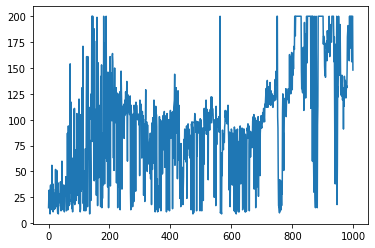

In [14]:
plt.plot(player.score_history)

In [15]:
eval_player = Agent(output_dir, n_inputs, n_actions, hidden_layer_sizes,
               epsilon=(0.99, 0.9999, 0.05, 100, 1.05, 1.01),
               batch_size=batch_size, update_every=update_every, eval_mode=True, model_params_path=os.path.join(output_dir, "model.pt"),
               optimizer_args={"lr": 0.01})

In [16]:
eval_scores = []

for e in range(100):
    
    cur_state = to_torch(env.reset(), device)

    for i in range(200):

        env.render()

        next_state, reward, is_done, info = env.step(eval_player.policy_net(cur_state).argmax().item())

        cur_state = to_torch(next_state, device)

        if is_done:

            break
    
    if e % 10 == 9:
        
        print("Evaluated {} episodes".format(e))
            
    eval_scores.append(i)

Evaluated 9 episodes
Evaluated 19 episodes
Evaluated 29 episodes
Evaluated 39 episodes
Evaluated 49 episodes
Evaluated 59 episodes
Evaluated 69 episodes
Evaluated 79 episodes
Evaluated 89 episodes
Evaluated 99 episodes


In [17]:
env.close()

In [18]:
np.mean(eval_scores)

199.0